# TCS Data Challenge


# Clustering

1 - Data Loading

In [0]:
# Required imports

from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default()) # for loading directly from the link

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import matplotlib.pyplot as plt


In [2]:
# Get the dataset

wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1ef0RdVGR52EOjUl1Z66D66LbA4ammSy_WLW_us9HUhY/edit?usp=sharing')
sheet = wb.worksheet('TCS_data257')
raw_data = sheet.get_all_values()
data_main = pd.DataFrame.from_records(raw_data[1:], columns=raw_data[0])
data_main.head()

,Timestamp,1. Are we becoming Anti Consumerists and or Post Consumerists ? Are you aware of these terms ?https://sarasotainstitute.global/the-consumer-in-the-age-of-coronavirus/,2. How did you first hear about survey?,In what country do you currently reside?,What state / city do you currently live in?,What is your age group?,What is your gender?,Which race/ethnicity best describes you? (Please choose only one.),What is the size of your family / dependents,What is your total household income per year?,What is the highest level of education you have completed?,What best describes your Profession,My residence is a...,What is your personal interpretation of this pandemic? Select all that apply.,What could be the new normal? Select all statements that you agree with.,How do you think your personal household expenditure will be impacted? [Food and groceries expenditure],"How do you think your personal household expenditure will be impacted? [Healthcare medical expenditure (Pharmacy, etc)]","How do you think your personal household expenditure will be impacted? [Utilities expenditure (power, gas, electricity, broadband, mobile, etc)]",How do you think your personal household expenditure will be impacted? [Residence expenditure (home mortgage or rent etc)],"How do you think your personal household expenditure will be impacted? [Educational expenditure (schooling, tuition fees, professional career development programs, etc)]","How do you think your personal household expenditure will be impacted? [Entertainment expenditure (vacations, movies, concerts, dining out, etc)]","How do you think your personal household expenditure will be impacted? [Appliances and Electronics expenditure (Consumer goods, etc)]","How do you think your personal household expenditure will be impacted? [High value expenditure (vehicles, boats, vacation homes, etc)]","How do you think your personal household expenditure will be impacted? [Business expenditure (office space, office infrastructure, etc)]","How do you think your personal household expenditure will be impacted? [Wellness expenditure (gym, health clubs, fitness trainers, etc)]","How do you think your personal household expenditure will be impacted? [Luxury goods expenditure (Fashion wear, etc)]","How do you think your personal household expenditure will be impacted? [Insurance expenditure (Health, life insurance premiums, etc)]",How do you think your personal household expenditure will be impacted? [Investments (% of income towards investments & savings)],How do you think your personal household expenditure will be impacted? [Any other (please specify)],"What kind of Post-consumerist do you think you may become Post COVID-19? [Life Simplifier : I want a simple life, want to eat and buy less]",What kind of Post-consumerist do you think you may become Post COVID-19? [De-growth Activist : conservation | reducing our material needs],What kind of Post-consumerist do you think you may become Post COVID-19? [Climate Activist : respect for nature | future of our planet],What kind of Post-consumerist do you think you may become Post COVID-19? [Sane Food Chooser : I am turning to plant based and organic food choices],"What kind of Post-consumerist do you think you may become Post COVID-19? [Conservationist : D.I.Y, reuse, repair, redecorate existing goods]","What kind of Post-consumerist do you think you may become Post COVID-19? [Remote everything : Rural dwelling, digital life choices, reduced travel and urban clutter]",What kind of Post-consumerist do you think you may become Post COVID-19? [Most of everything from the above list],What kind of Post-consumerist do you think you may become Post COVID-19? [A little of everything from the above list],"What kind of Post-consumerist do you think you may become Post COVID-19? [No way, I am just waiting for the stay-at-home restrictions to be lifted and get back to my usual lifestyle as it was pre-COVID-19]",What kind of Post-consumerist do you think you may become P

In [3]:
column_names = ['timestamp', 'consumerism', 'hear_survey', 'country_in', 'citystate_in', 'age_group', 'gender', 'race_enthnicity', #8
                'family_size', 'household_income_pa', 'education', 'profession', 'residence', 'pandemic_interpretation', 'new_normal', #15
                'expen_impt_food_groceries', 'expen_impt_healthcare', 'expen_impt_utilities', 'expen_impt_residence', 
                'expen_impt_education', 'expen_impt_entertainment', 'expen_impt_appliances', 'expen_impt_highvalue', 
                'expen_impt_business_expen', 'expen_impt_wellness', 'expen_impt_luxury', 'expen_impt_insurance', 
                'expen_impt_investments', 'expen_impt_other', #29
                'postcov_life_simplifier', 'postcov_degrowth_activist', 'postcov_climate_activist', 'postcov_sane_food', 
                'postcov_conservationist', 'postcov_remote_everything', 'postcov_most', 'postcov_little', 'postcov_no_change', 'postcov_other', #39
                'perspective_text', 'perspective_other', 'Email Address'] #42
data_main.columns = column_names
data_main.head()

,timestamp,consumerism,hear_survey,country_in,citystate_in,age_group,gender,race_enthnicity,family_size,household_income_pa,education,profession,residence,pandemic_interpretation,new_normal,expen_impt_food_groceries,expen_impt_healthcare,expen_impt_utilities,expen_impt_residence,expen_impt_education,expen_impt_entertainment,expen_impt_appliances,expen_impt_highvalue,expen_impt_business_expen,expen_impt_wellness,expen_impt_luxury,expen_impt_insurance,expen_impt_investments,expen_impt_other,postcov_life_simplifier,postcov_degrowth_activist,postcov_climate_activist,postcov_sane_food,postcov_conservationist,postcov_remote_everything,postcov_most,postcov_little,postcov_no_change,postcov_other,perspective_text,perspective_other,Email Address
0,6/6/2020 15:15:46,"No, never heard them before",Word of Mouth,India,Hyderabad,19 to 24,Female,Do not wish to disclose,Single,"Less than $24,999",Graduated from college,Employed in Private firm,town-home,"Made me aware how fragile our health is, Need ...","Enhanced rigor in personal wellness, safety & ...",Cannot Say,Increase Slightly,Increase Slightly,Remain Constant,Remain Constant,Reduced Slightly,Increase Slightly,Reduced Significantly,Remain Constant,Increase Slightly,Remain Constant,Increase Slightly,Increase Slightly,,,,,,,,Lightly Agree,,,,Lot of unnecessary spendings are scraped out. ...,,
1,6/6/2020 15:51:37,Yes but only aware of the terms,Word of Mouth,India,Andhra pradesh,19 to 24,Male,Do not wish to disclose,3-4,"$25,000 to $49,999",Graduated from college,Employed in Private firm,One to two bedroom apartment,"Made me aware how fragile our health is, Need ...","Enhanced rigor in personal wellness, safety & ...",Remain Constant,Remain Constant,Increase Slightly,Remain Constant,Remain Constant,Reduced Significantly,Reduced Slightly,Remain Constant,Remain Constant,Remain Constant,Reduced Slightly,Increase Slightly,Increase Slightly,Cannot Say,Neither Agree nor Disagree,Lightly Disagree,Strongly Agree,Lightly Agree,Lightly Agree,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,Lightly Agree,Neither Agree nor Disagree,,,
2,6/6/2020 15:58:54,"No, never heard them before",,India,Telangana,19 to 24,Male,Asian / Pacific Islander,3-4,"Less than $24,999",Graduated from college,Student,3+ bedroom apartment,Shocked by the inadequacy of our health system...,Practicing more physical distancing habits in ...,Remain Constant,Remain Constant,Remain Constant,Remain Constant,Remain Constant,Remain Constant,Remain Constant,Remain Constant,Remain Constant,Increase Slightly,Remain Constant,Remain Constant,Remain Constant,Cannot Say,Neither Agree nor Disagree,Neither Agree nor Disagree,Strongly Agree,Neither Agree nor Disagree,Lightly Agree,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,Lightly Agree,Neither Agree nor Disagree,,,
3,6/6/2020 20:57:33,"No, never heard them before",Swarna akka told to do so,United States,Texas,19 to 24,Male,Asian / Pacific Islander,Single,"$100,000 to $149,999",Masters degree,Employed in Private firm,One to two bedroom apartment,"Made me aware how fragile our health is, Need ...","Enhanced rigor in personal wellness, safety & ...",Increase Significantly,Cannot Say,Remain Constant,Remain Constant,Remain Constant,Reduced Significantly,Reduced Significantly,Reduced Significantly,Reduced Significantly,Reduced Significantly,Reduced Significantly,Remain Constant,Increase Slightly,Remain Constant,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,,,
4,6/6/2020 21:00:51,Yes but only aware of the terms,Word of Mouth,India,Andhra Pradesh,19 to 24,Male,Do not wish to disclose,3-4,"Less than $24,999",Graduated from college,Seeking employment,One to two bedroom apartment,"Made me aware how fragile our health 

2 - Missing data analysis and imputation

In [4]:
data_main = data_main.replace('', np.nan)
data_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   timestamp                  257 non-null    object 
 1   consumerism                256 non-null    object 
 2   hear_survey                248 non-null    object 
 3   country_in                 256 non-null    object 
 4   citystate_in               254 non-null    object 
 5   age_group                  256 non-null    object 
 6   gender                     257 non-null    object 
 7   race_enthnicity            255 non-null    object 
 8   family_size                255 non-null    object 
 9   household_income_pa        242 non-null    object 
 10  education                  256 non-null    object 
 11  profession                 256 non-null    object 
 12  residence                  254 non-null    object 
 13  pandemic_interpretation    254 non-null    object 

In [5]:
data_main = data_main[data_main['consumerism'].notna()]
data_to_cluster = data_main[['country_in', 'age_group', 'gender', 'race_enthnicity', 'family_size', 'household_income_pa', 
                             'education', 'profession', 'residence', 'pandemic_interpretation']]
# data_to_cluster.head()
data_to_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256 entries, 0 to 256
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   country_in               255 non-null    object
 1   age_group                255 non-null    object
 2   gender                   256 non-null    object
 3   race_enthnicity          254 non-null    object
 4   family_size              254 non-null    object
 5   household_income_pa      241 non-null    object
 6   education                255 non-null    object
 7   profession               255 non-null    object
 8   residence                253 non-null    object
 9   pandemic_interpretation  253 non-null    object
dtypes: object(10)
memory usage: 22.0+ KB


In [6]:
def get_string_list(x):
    if type(x['pandemic_interpretation']) == str:
        # return x['pandemic_interpretation'].split(', ')
        split = x['pandemic_interpretation'].split(', ')
        if 'Family' in split:
            split.remove('Family')
            split.remove('friends and community come first')
            split.append('Family, friends and community come first')

        if 'More home cooking' in split:
            split.remove('More home cooking')
            split.remove('more kitchen gardening and less eating out')
            split.append('More home cooking more kitchen gardening and less eating out')

        if 'Have become more conscious of fragility of the planet' in split:
            split.remove('Have become more conscious of fragility of the planet')
            split.remove('of air and water pollution')
            split.append('Have become more conscious of fragility of the planet of air and water pollution')

        return split
    else:
        return []

data_to_cluster2 = data_to_cluster.copy()
string_list = data_to_cluster.apply(get_string_list, axis=1)
data_to_cluster2['pandemic_interpretation'] = string_list
# data_to_cluster2.head()


from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
data_to_cluster2 = data_to_cluster2.join(pd.DataFrame(mlb.fit_transform(data_to_cluster2.pop('pandemic_interpretation')),
                                                    columns=mlb.classes_,
                                                    index=data_to_cluster.index))
data_to_cluster2.head()

,country_in,age_group,gender,race_enthnicity,family_size,household_income_pa,education,profession,residence,"Family, friends and community come first",Have become more conscious of fragility of the planet of air and water pollution,Made me aware how fragile our health is,More home cooking more kitchen gardening and less eating out,Moving away from addiction to materialism and sensing other paths to a good life,Need to eat more healthy foods to have a greater resistance to germs and flus,Shocked by the inadequacy of our health systems and its great cost,The sudden loss of jobs will remain a trauma even after jobs come back,Will spend and save money more carefully
0,India,19 to 24,Female,Do not wish to disclose,Single,"Less than $24,999",Graduated from college,Employed in Private firm,town-home,0,1,1,1,0,1,1,0,0
1,India,19 to 24,Male,Do not wish to disclose,3-4,"$25,000 to $49,999",Graduated from college,Employed in Private firm,One to two bedroom apartment,1,0,1,1,1,1,1,1,1
2,India,19 to 24,Male,Asian / Pacific Islander,3-4,"Less than $24,999",Graduated from college,Student,3+ bedroom apartment,1,1,0,0,1,0,1,0,0
3,United States,19 to 24,Male,Asian / Pacific Islander,Single,"$100,000 to $149,999",Masters degree,Employed in Private firm,One to two bedroom apartment,1,0,1,1,0,1,1,0,0
4,India,19 to 24,Male,Do not wish to disclose,3-4,"Less than $24,999",Graduated from college,Seeking employment,One to two bedroom apartment,0,0,1,1,1,0,1,0,0


https://towardsdatascience.com/clustering-with-k-means-1e07a8bfb7ca

In [7]:
ohe_data_to_cluster = pd.get_dummies(data_to_cluster2[['country_in', 'age_group', 'gender', 'race_enthnicity', 'family_size', 'household_income_pa', 
                               'education', 'profession', 'residence']])
data_to_cluster2 = pd.concat([data_to_cluster2.drop(['country_in', 'age_group', 'gender', 'race_enthnicity', 'family_size', 'household_income_pa', 
                                  'education', 'profession', 'residence'], axis=1), 
           ohe_data_to_cluster], axis=1)
data_to_cluster2.head()      

,"Family, friends and community come first",Have become more conscious of fragility of the planet of air and water pollution,Made me aware how fragile our health is,More home cooking more kitchen gardening and less eating out,Moving away from addiction to materialism and sensing other paths to a good life,Need to eat more healthy foods to have a greater resistance to germs and flus,Shocked by the inadequacy of our health systems and its great cost,The sudden loss of jobs will remain a trauma even after jobs come back,Will spend and save money more carefully,country_in_Australia,country_in_Canada,country_in_Germany,country_in_Hungary,country_in_India,country_in_Ireland,country_in_Other (Please specify),country_in_Qatar,country_in_Sweden,country_in_United Arab Emirates,country_in_United Kingdom,country_in_United States,age_group_19 to 24,age_group_25 to 34,age_group_35 to 44,age_group_45 to 54,age_group_55 to 64,age_group_65 to 74,age_group_75 or older,age_group_Do not wish to disclose,age_group_Less than 18,gender_Female,gender_Fish,gender_Male,gender_Prefer not to say,race_enthnicity_American Indian or Alaskan Native,race_enthnicity_Asian / Pacific Islander,race_enthnicity_Do not wish to disclose,race_enthnicity_Fish,race_enthnicity_Hindu,race_enthnicity_Indian,...,"household_income_pa_$150,000 or More","household_income_pa_$25,000 to $49,999","household_income_pa_$50,000 to $74,999","household_income_pa_$75,000 to $99,999",household_income_pa_0,household_income_pa_Currently a student,household_income_pa_Do not wish to disclose,household_income_pa_IDk,"household_income_pa_Less than $24,999",household_income_pa_Prefer not to say,education_Doctorate,education_Double graduation,education_Engineering,education_Graduated from college,education_High school,education_I f**ked up,education_Masters degree,education_Post Grad,education_Under graduate,profession_Employed in Private firm,profession_Employed in Public or Government firm,profession_Home maker,profession_Own Business - Small & Medium,profession_Retired,profession_Seeking employment,profession_Self employed Professional,profession_Student,residence_3+ bedroom apartment,residence_Bungalow,residence_Castle/Chateau/Palace/Cottage/Ranch/etc,residence_Condominium,residence_Hostel,residence_I live in jungle,residence_One to two bedroom apartment,residence_PG,residence_Row House,residence_Single family (detached),residence_Studio apartment,residence_sharing,residence_town-home
0,0,1,1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,1,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [8]:
data_to_cluster2.shape

(256, 89)

In [0]:
def get_clustering_information(K, data):
    silhouette_scores = []
    ch_scores = []
    y_hats = []
    for k in K:
        k_means = KMeans(n_clusters=k)
        model = k_means.fit(data)
        y_hat = k_means.predict(data_to_cluster2)
        y_hats.append(y_hat)
        # silhouette coefficient
        labels = k_means.labels_
        silhouette_scores.append(metrics.silhouette_score(data_to_cluster2, labels, metric = 'euclidean'))
        # CH score
        ch_scores.append(metrics.calinski_harabasz_score(data_to_cluster2, labels))
    return y_hats, silhouette_scores, ch_scores

def plot_graph(X, y, title, xlabel, ylabel, need_log_x, lab):
    plt.plot(X, y, label=lab)
    if (need_log_x == 1):
        plt.xscale('log')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    if lab:
        plt.legend()

In [0]:
K = list(range(2, 13))
y_hats, silhouette_scores, ch_scores = get_clustering_information(K, data_to_cluster2)

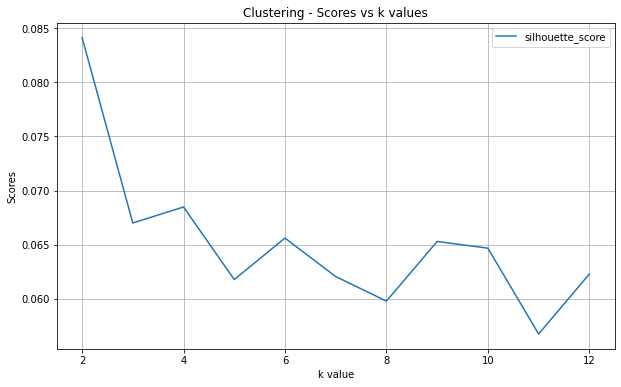

In [29]:
plt.figure(figsize=(10, 6))
plot_graph(K, silhouette_scores, 'Clustering - Scores vs k values', 'k value', 'Scores', 0, 'silhouette_score')

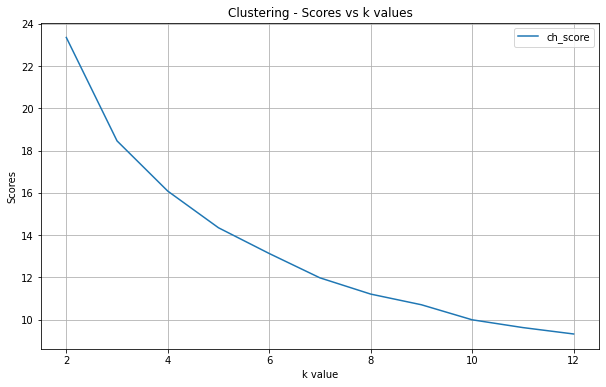

In [30]:
plt.figure(figsize=(10, 6))
plot_graph(K, ch_scores, 'Clustering - Scores vs k values', 'k value', 'Scores', 0, 'ch_score')

As 2 clusters have the best scores, we proceed with dividing the respondants into two categories.